In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
from pathlib import Path

# estando el notebook en notebooks/, la raíz es el padre
ROOT = Path.cwd().parent
sys.path.insert(0, str(ROOT))

#Archivos propios
import src.models as models
import src.preprocessing as pre
import src.data_splitting as datasplit
import src.metrics as metrics


CARGO EL DATASET E IMPRIMO PARA ANALIZAR LAS COLUMNAS

In [2]:

df = pd.read_csv(ROOT / "data" / "casas_dev.csv")
df_test = pd.read_csv(ROOT / "data" / "casas_test.csv")

print(df.info())
print(df.head())
print(df.tail())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   precio            1545 non-null   float64
 1   tipo              1600 non-null   object 
 2   Área              1600 non-null   float64
 3   metros_cubiertos  1600 non-null   float64
 4   unidades          1600 non-null   object 
 5   ambientes         1600 non-null   int64  
 6   pisos             748 non-null    float64
 7   pileta            1600 non-null   bool   
 8   lat               1600 non-null   float64
 9   lon               1600 non-null   float64
 10  edad              1451 non-null   float64
dtypes: bool(1), float64(7), int64(1), object(2)
memory usage: 126.7+ KB
None
          precio   tipo        Área  metros_cubiertos unidades  ambientes  \
0  159001.587058  depto  721.976728        703.066245     sqft          5   
1   42435.625078   casa  229.512155        113.935

c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

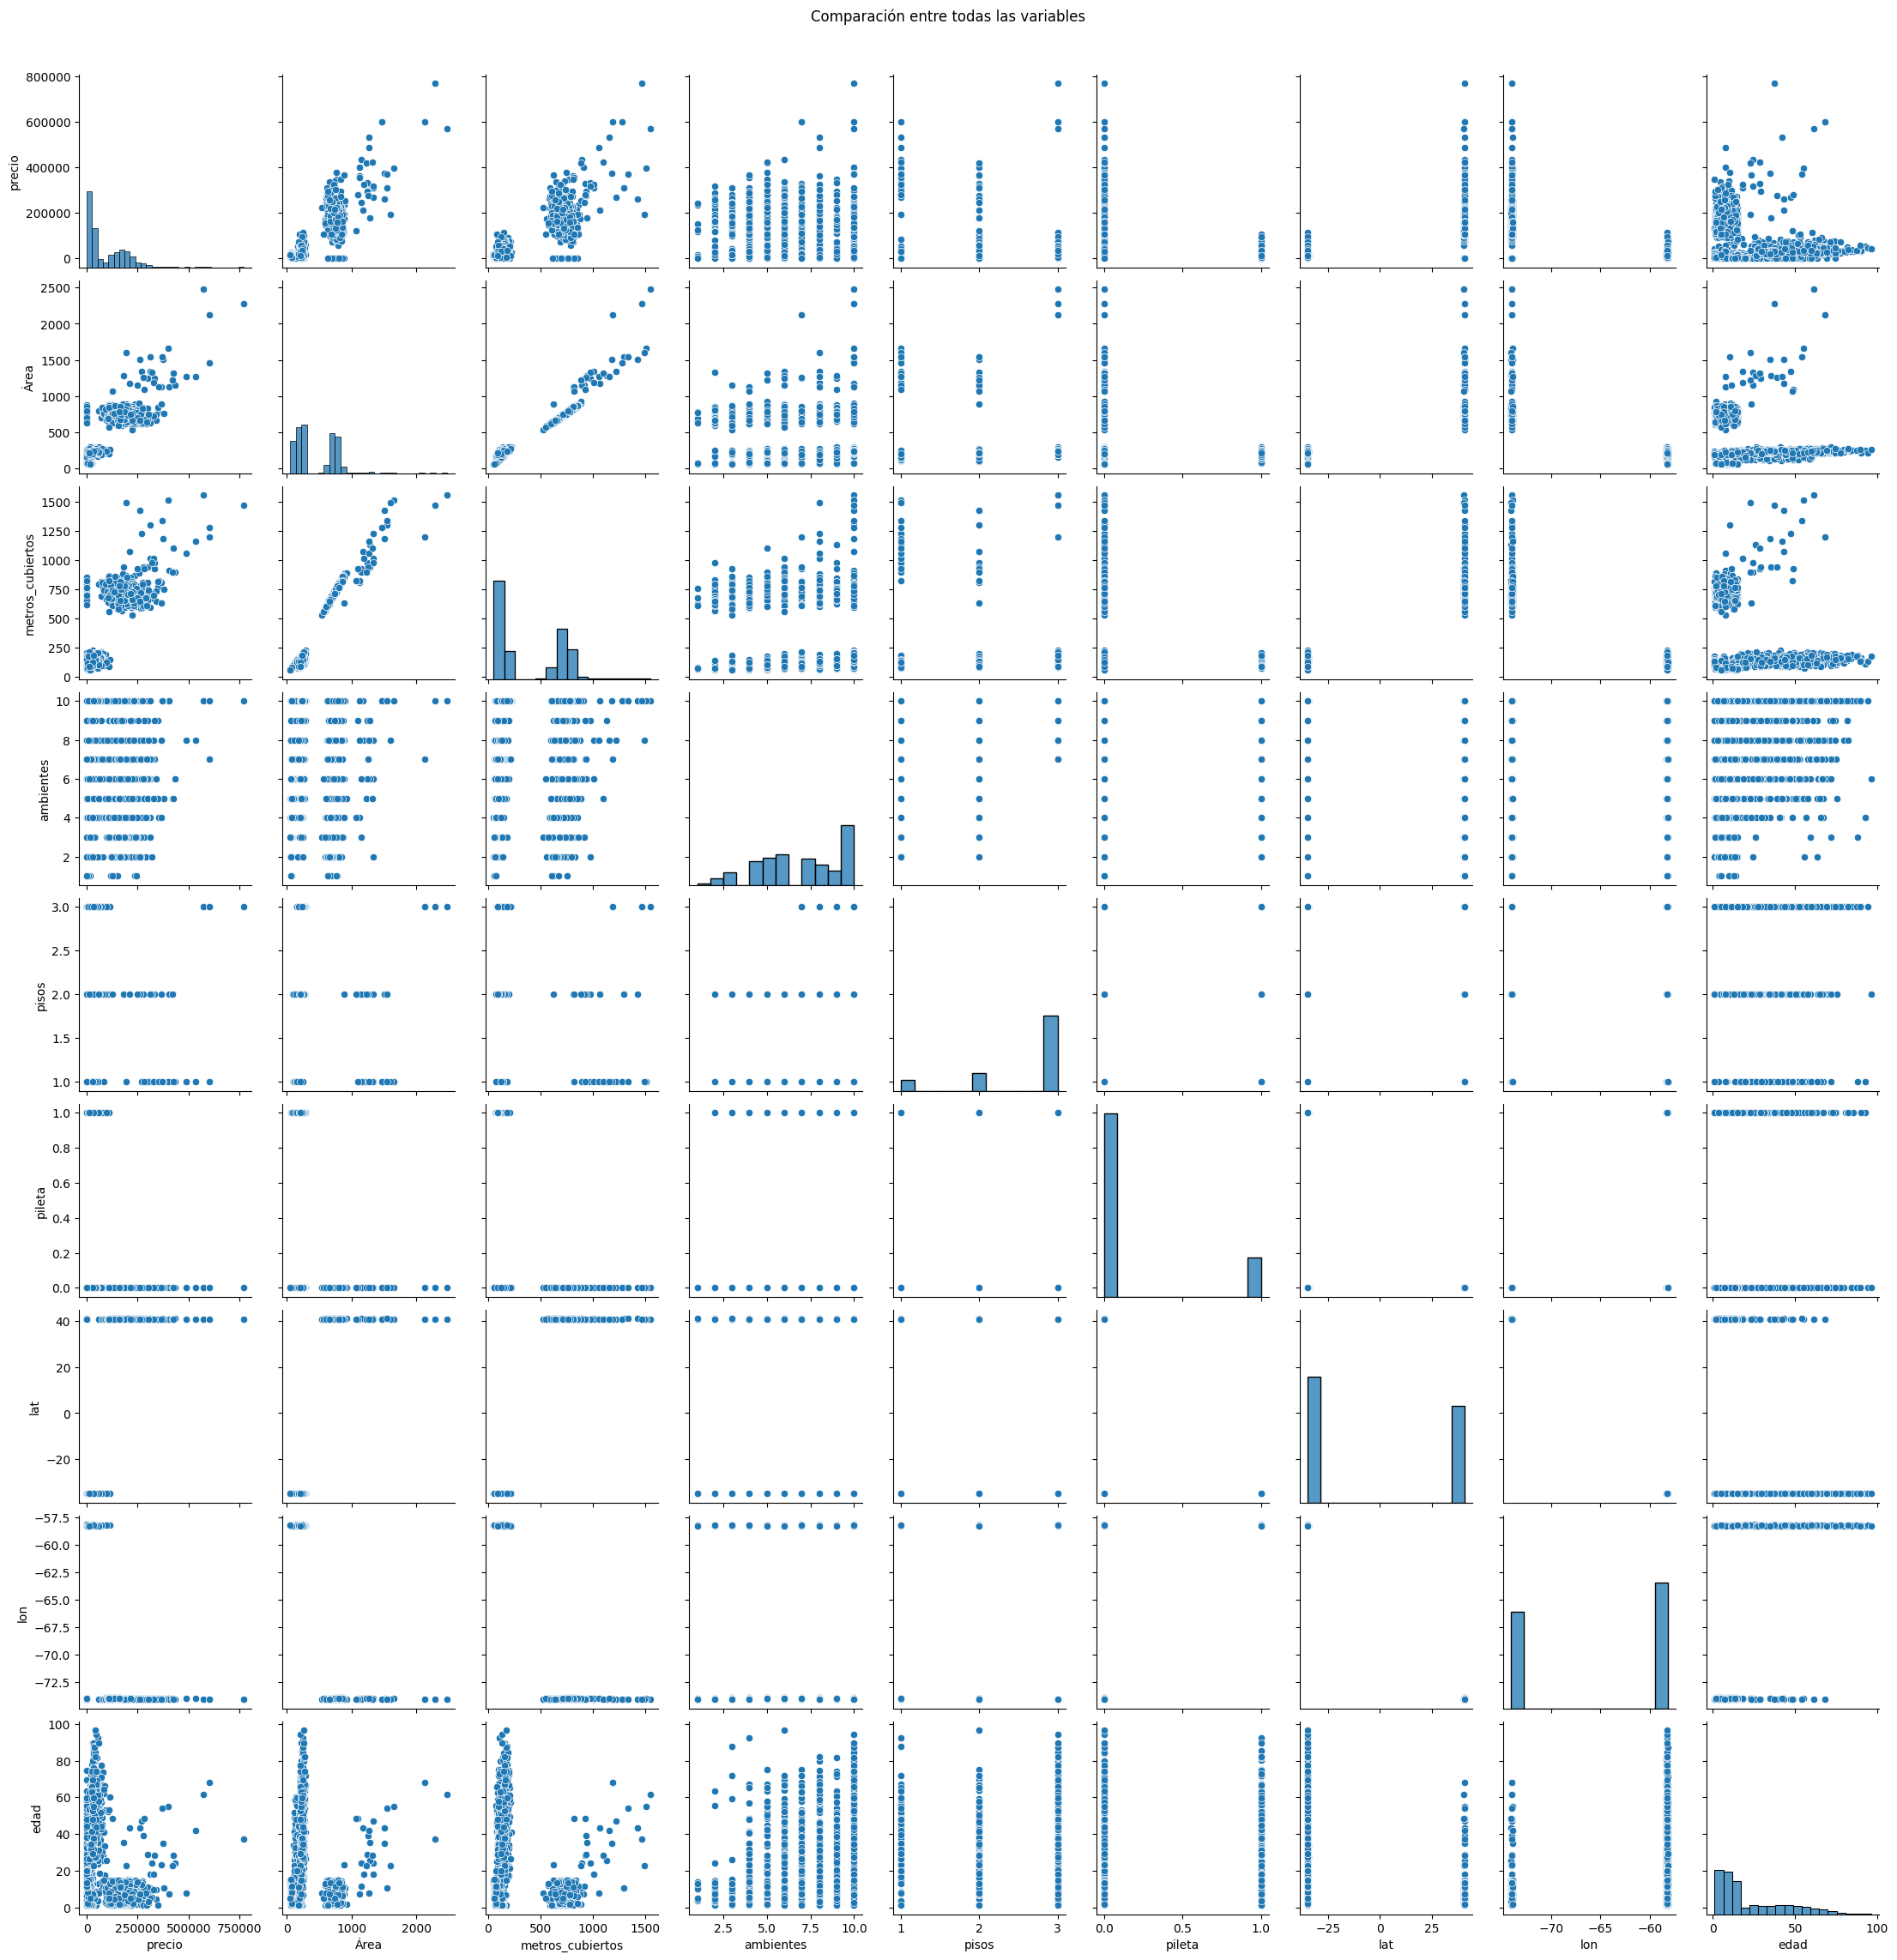

In [53]:
#Hacer scatter plots de las columnas para comparar todas con todas
sns.pairplot(df)
plt.suptitle('Comparación entre todas las variables', y=1.02)
plt.show()

AL PARECER FALTAN DATOS EN LA COLUMNA DE PISOS Y EDAD. TAMBIEN HAY DIFERENCIAS EN LAS UNIDADES (ALGUNAS EN M2 Y OTRAS EN SQFT)

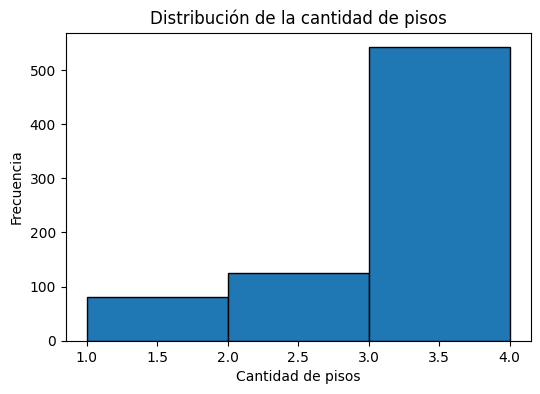

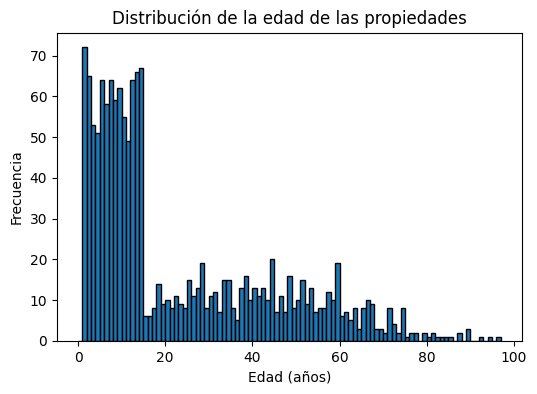

In [54]:
#histograma de la columna pisos.
plt.figure(figsize=(6,4))
plt.hist(df['pisos'].dropna(), bins=range(1, int(df['pisos'].max())+2), edgecolor='black')
plt.xlabel('Cantidad de pisos')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad de pisos')
plt.show()

# Histograma de la columna edad
plt.figure(figsize=(6,4))
plt.hist(df['edad'].dropna(), bins=range(0, int(df['edad'].max())+2), edgecolor='black')
plt.xlabel('Edad (años)')
plt.ylabel('Frecuencia')
plt.title('Distribución de la edad de las propiedades')
plt.show()


EMPIEZO CON LA LIMPIEZA DEL DATASET

In [55]:
# Creo una copia de los datos para limpiar
df_clean = df.copy() 

In [56]:
# Convertir los valores de 'metros_cubiertos' de sqft a m2 donde corresponda
df_clean.loc[df_clean['unidades'] == 'sqft', 'metros_cubiertos'] = df_clean.loc[df_clean['unidades'] == 'sqft', 'metros_cubiertos'] * 0.092903

# Convertir los valores de 'area' de sqft a m2 donde corresponda
df_clean.loc[df_clean['unidades'] == 'sqft', 'Área'] = df_clean.loc[df_clean['unidades'] == 'sqft', 'Área'] * 0.092903

# Eliminar la columna unidades
df_clean.drop(columns=['unidades'], inplace=True)

Hay datos Nulos de Precio. Elimino esas filas

In [57]:
# Eliminar filas con precio Nan o precio 0
df_clean = df_clean[df_clean['precio'].notna() & (df_clean['precio'] != 0)]


Relleno la columna edad con la Mediana de la columna.

In [58]:
#Calculo la mediana de la columna y la relleno
df_clean['edad'].fillna(df_clean['edad'].median(), inplace=True)


C:\Users\Lucas\AppData\Local\Temp\ipykernel_18284\2425125511.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['edad'].fillna(df_clean['edad'].median(), inplace=True)


In [59]:
print(df_clean.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1488 entries, 0 to 1599
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   precio            1488 non-null   float64
 1   tipo              1488 non-null   object 
 2   Área              1488 non-null   float64
 3   metros_cubiertos  1488 non-null   float64
 4   ambientes         1488 non-null   int64  
 5   pisos             689 non-null    float64
 6   pileta            1488 non-null   bool   
 7   lat               1488 non-null   float64
 8   lon               1488 non-null   float64
 9   edad              1488 non-null   float64
dtypes: bool(1), float64(7), int64(1), object(1)
memory usage: 117.7+ KB
None


In [60]:
#Relleno la columna pisos con 1 si el tipo es departamento
df_clean.loc[df_clean['tipo'] == 'depto', 'pisos'] = 1



In [61]:
print(df_clean.info())

print(df_clean.head())

<class 'pandas.core.frame.DataFrame'>
Index: 1488 entries, 0 to 1599
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   precio            1488 non-null   float64
 1   tipo              1488 non-null   object 
 2   Área              1488 non-null   float64
 3   metros_cubiertos  1488 non-null   float64
 4   ambientes         1488 non-null   int64  
 5   pisos             1488 non-null   float64
 6   pileta            1488 non-null   bool   
 7   lat               1488 non-null   float64
 8   lon               1488 non-null   float64
 9   edad              1488 non-null   float64
dtypes: bool(1), float64(7), int64(1), object(1)
memory usage: 117.7+ KB
None
          precio   tipo        Área  metros_cubiertos  ambientes  pisos  \
0  159001.587058  depto   67.073804         65.316963          5    1.0   
1   42435.625078   casa  229.512155        113.935741          4    1.0   
3  135972.861876  depto   72.15

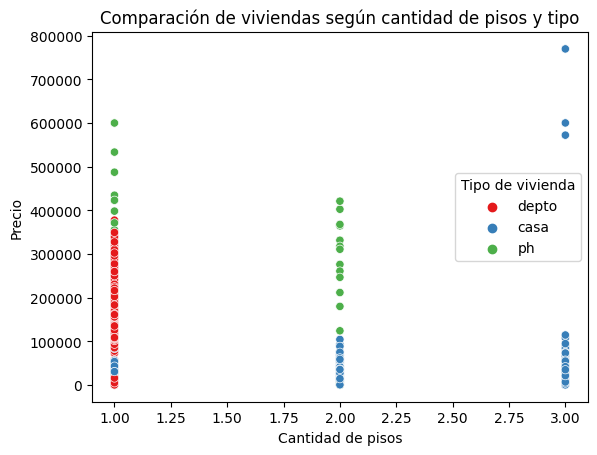

In [62]:
#Quiero comparar las viviendas segun la cantidad de pisos diferenciando por color si son casas, deptos o ph
sns.scatterplot(data=df_clean, x='pisos', y='precio', hue='tipo', palette='Set1')
plt.xlabel('Cantidad de pisos')
plt.ylabel('Precio')
plt.title('Comparación de viviendas según cantidad de pisos y tipo')
plt.legend(title='Tipo de vivienda')
plt.show()


In [63]:
# Codificar la columna 'tipo' usando la función de preprocesamiento
df_clean = pre.encode_tipo_column(df_clean)
print(df_clean.head())

          precio        Área  metros_cubiertos  ambientes  pisos  pileta  \
0  159001.587058   67.073804         65.316963          5    1.0   False   
1   42435.625078  229.512155        113.935741          4    1.0    True   
3  135972.861876   72.158654         69.462937          5    1.0   False   
4   49758.465224  249.165942        102.023922          5    2.0   False   
5    7256.796507  170.849136         77.355172          6    2.0    True   

         lat        lon       edad  depto     ph  
0  40.738155 -73.992277  13.061086   True  False  
1 -34.710794 -58.280446  67.202318  False  False  
3  40.847320 -74.011712  13.835526   True  False  
4 -34.777778 -58.255182  63.200110  False  False  
5 -34.693175 -58.240397   4.305892  False  False  


In [64]:
print(df_clean.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1488 entries, 0 to 1599
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   precio            1488 non-null   float64
 1   Área              1488 non-null   float64
 2   metros_cubiertos  1488 non-null   float64
 3   ambientes         1488 non-null   int64  
 4   pisos             1488 non-null   float64
 5   pileta            1488 non-null   bool   
 6   lat               1488 non-null   float64
 7   lon               1488 non-null   float64
 8   edad              1488 non-null   float64
 9   depto             1488 non-null   bool   
 10  ph                1488 non-null   bool   
dtypes: bool(3), float64(7), int64(1)
memory usage: 109.0 KB
None


In [65]:
#Separo en train y validation
train_df, val_df = datasplit.split_train_val(df_clean,train_frac=0.8, random_state=42)

In [66]:
# Modelo M1 solo con Area con Pseudoinversa
X_train_m1 = train_df[["Área"]].values
y_train = train_df["precio"].values
features = ["Área"]

modelo_m1_svd = models.RegresionLineal(X_train_m1, y_train, feature_names=features)
modelo_m1_svd.entrenar_pseudoinversa()
modelo_m1_svd.imprimir_coeficientes()

modelo_m1_gd = models.RegresionLineal(X_train_m1, y_train, feature_names=features)
modelo_m1_gd.entrenar_gradiente_descendente()
modelo_m1_gd.imprimir_coeficientes()    

Coeficientes del modelo:
  Bias: 97681.6452
  Área: -54120.8415
Coeficientes del modelo:
  Bias: 97677.4282
  Área: -54118.5050


In [67]:
train_df, val_df = datasplit.split_train_val(df_clean,train_frac=0.8, random_state=42)

# Modelo M2 con Area y Pileta con Pseudoinversa
X_train_m2 = train_df[["Área", "pileta"]].values
y_train = train_df["precio"].values
features = ["Área", "Pileta"]

modelo_m2 = models.RegresionLineal(X_train_m2, y_train, feature_names=features)
modelo_m2.entrenar_pseudoinversa()
modelo_m2.imprimir_coeficientes()

modelo_m2_gd = models.RegresionLineal(X_train_m2, y_train, feature_names=features)
modelo_m2_gd.entrenar_gradiente_descendente()
modelo_m2_gd.imprimir_coeficientes()

Coeficientes del modelo:
  Bias: 97681.6452
  Área: -52453.9135
  Pileta: -3261.7815
Coeficientes del modelo:
  Bias: 97677.4282
  Área: -52271.0264
  Pileta: -3444.6550


In [68]:
train_df, val_df = datasplit.split_train_val(df_clean,train_frac=0.8, random_state=42)

#Modelo M3 usando 6 caracteristicas
X_train_m3 = train_df[["Área", "pileta", "ambientes", "edad", "metros_cubiertos", "pisos"]].values
y_train = train_df["precio"].values
features = ["Área", "Pileta", "Ambientes", "Edad", "Garaje", "Jardín"]

modelo_m3 = models.RegresionLineal(X_train_m3, y_train, feature_names=features)
modelo_m3.entrenar_pseudoinversa()
modelo_m3.imprimir_coeficientes()

Coeficientes del modelo:
  Bias: 97681.6452
  Área: -56388.3472
  Pileta: -2912.7030
  Ambientes: -1455.1906
  Edad: 9131.9026
  Garaje: -1235.9001
  Jardín: -1133.3838


In [69]:
# Construyo caracteristicas derivadas de las anteriores.

# Copiamos para no pisar el original
df_feat = df_clean.copy()

# 1. Relaciones de tamaños
df_feat["relacion_cubiertos"] = df_feat["metros_cubiertos"] / (df_feat["Área"] + 1e-6)
df_feat["m2_por_ambiente"] = df_feat["metros_cubiertos"] / (df_feat["ambientes"] + 1e-6)

# 2. Interacciones
df_feat["pisos_x_ambientes"] = df_feat["pisos"] * df_feat["ambientes"]
df_feat["edad_x_metros"] = df_feat["edad"] * df_feat["metros_cubiertos"]

# 3. Transformaciones no lineales
df_feat["log_area"] = np.log1p(df_feat["Área"])            # log(Area + 1)
df_feat["log_precio"] = np.log1p(df_feat["precio"])        # log(precio + 1)

# 4. Variables categóricas enriquecidas
df_feat["densidad_construccion"] = df_feat["pisos"] / (df_feat["Área"] + 1e-6)

# 5. Variables indicadoras
df_feat["es_moderno"] = (df_feat["edad"] < 10).astype(int)
df_feat["es_grande"] = (df_feat["Área"] > 200).astype(int)

# 6. Divido las propiedades en dos grupos dependiendo de la zona
df_feat["zona"] = (df_feat["lat"] > 0).astype(int)

# 7. Interacción entre zona y tamaño
df_feat["zona_x_metros"] = df_feat["zona"] * df_feat["metros_cubiertos"]

# Chequear
df_feat.head()


,precio,Área,metros_cubiertos,ambientes,pisos,pileta,lat,lon,edad,depto,...,m2_por_ambiente,pisos_x_ambientes,edad_x_metros,log_area,log_precio,densidad_construccion,es_moderno,es_grande,zona,zona_x_metros
0,159001.587058,67.073804,65.316963,5,1.0,False,40.738155,-73.992277,13.061086,True,...,13.063390,5.0,853.110496,4.220592,11.976676,0.014909,0,0,1,65.316963
1,42435.625078,229.512155,113.935741,4,1.0,True,-34.710794,-58.280446,67.202318,False,...,28.483928,4.0,7656.745902,5.440304,10.655767,0.004357,0,1,0,0.000000
3,135972.861876,72.158654,69.462937,5,1.0,False,40.847320,-74.011712,13.835526,True,...,13.892585,5.0,961.056283,4.292630,11.820218,0.013858,0,0,1,69.462937
4,49758.465224,249.165942,102.023922,5,2.0,False,-34.777778,-58.255182,63.200110,False,...,20.404780,10.0,6447.923121,5.522124,10.814956,0.008027,0,1,0,0.000000
5,7256.796507,170.849136,77.355172,6,2.0,True,-34.693175,-58.240397,4.305892,False,...,12.892527,12.0,333.083056,5.146617,8.889832,0.011706,1,0,0,0.000000


In [70]:
train_df, val_df = datasplit.split_train_val(df_feat,train_frac=0.8, random_state=42)

# Modelo M4 usando todas las caracteristicas
X_train_m4 = df_feat.drop(columns=['precio']).values
y_train_m4 = df_feat['precio'].values
features_m4 = df_feat.drop(columns=['precio']).columns.tolist()


modelo_m4 = models.RegresionLineal(X_train_m4, y_train_m4, feature_names=features_m4)
modelo_m4.entrenar_pseudoinversa()
modelo_m4.imprimir_coeficientes()

modelo_m4_gd = models.RegresionLineal(X_train_m4, y_train_m4, feature_names=features_m4)
modelo_m4_gd.entrenar_gradiente_descendente()
modelo_m4_gd.imprimir_coeficientes()


Coeficientes del modelo:
  Bias: 96919.3582
  Área: 49554.7476
  metros_cubiertos: 59903.2401
  ambientes: 1749.8879
  pisos: 18057.8567
  pileta: 1093.4432
  lat: 7748052.4062
  lon: -381172.8873
  edad: -2454.3093
  depto: -56188.4270
  ph: -1297.2558
  relacion_cubiertos: -73829.1164
  m2_por_ambiente: -377.1430
  pisos_x_ambientes: -2770.9424
  edad_x_metros: 5049.4118
  log_area: -249275.1469
  log_precio: 18310.7571
  densidad_construccion: -10412.6048
  es_moderno: 1766.5011
  es_grande: 4864.7584
  zona: -8178034.0311
  zona_x_metros: 121028.4499
Coeficientes del modelo:
  Bias: 96915.1740
  Área: -296.5421
  metros_cubiertos: -1070.6124
  ambientes: 1185.4536
  pisos: -2690.2083
  pileta: -218.6513
  lat: 13669.0632
  lon: -13631.6823
  edad: 56.1615
  depto: -8030.5641
  ph: 11989.1074
  relacion_cubiertos: -4021.9463
  m2_por_ambiente: -184.0084
  pisos_x_ambientes: -1048.5000
  edad_x_metros: 1423.3670
  log_area: -2099.9910
  log_precio: 26627.3682
  densidad_construccion:

In [71]:
# Modelo M5 con 50 caracteristicas

import numpy as np
import pandas as pd

# Supongamos que df_feat es tu dataset con features limpias y target "precio"
X_base = df_feat[["Área", "metros_cubiertos", "ambientes", "edad", "pisos"]].copy()

# Crear nuevas features polinómicas
X_poly = pd.DataFrame()

for col in X_base.columns:
    for p in range(1, 13):  # potencias de 1 hasta 12
        X_poly[f"{col}^{p}"] = X_base[col] ** p

# Ahora X_poly puede tener hasta 5 * 12 = 60 columnas
# Seleccionamos 50 (por ejemplo, las primeras 50)
X_poly = X_poly.iloc[:, :50]

# Matriz final
X = X_poly.values
y = df_feat["precio"].values

print("Shape X:", X.shape)  # debería ser (n_muestras, 50)

X_train_m5 = X
y_train_m5 = y
features = [f"{col}^{p}" for col in X_base.columns for p in range(1, 13)][:50]

modelo_m5 = models.RegresionLineal(X_train_m5, y_train_m5, feature_names=features)
modelo_m5.entrenar_pseudoinversa()
modelo_m5.imprimir_coeficientes()

modelo_m5_gd = models.RegresionLineal(X_train_m5, y_train_m5, feature_names=features)
modelo_m5_gd.entrenar_gradiente_descendente()
modelo_m5_gd.imprimir_coeficientes()


Shape X: (1488, 50)
Coeficientes del modelo:
  Bias: 96919.3656
  Área^1: -2094112711.5181
  Área^2: 28664724503.3687
  Área^3: -190635504061.1129
  Área^4: 795113694438.9603
  Área^5: -2268230228380.6162
  Área^6: 4587319942443.6260
  Área^7: -6657582131292.0293
  Área^8: 6900868170553.9355
  Área^9: -4993379253426.6152
  Área^10: 2398752248800.4507
  Área^11: -688039347252.4161
  Área^12: 89241782155.2427
  metros_cubiertos^1: 1283780847.3466
  metros_cubiertos^2: -15776919524.6890
  metros_cubiertos^3: 93983559317.6139
  metros_cubiertos^4: -355006226693.5858
  metros_cubiertos^5: 933152830280.2125
  metros_cubiertos^6: -1771115126272.8381
  metros_cubiertos^7: 2453368628982.0547
  metros_cubiertos^8: -2463001893206.9253
  metros_cubiertos^9: 1747511675811.7847
  metros_cubiertos^10: -831576468281.9253
  metros_cubiertos^11: 238248798567.1036
  metros_cubiertos^12: -31072692428.6097
  ambientes^1: 6739594.0658
  ambientes^2: -74255037.7633
  ambientes^3: 339226127.2570
  ambientes^4

  Bias: 97681.6452
  Área: -15712.3153
  metros_cubiertos: -1030.2424
  ambientes: 2449.8749
  pisos: -3827.5826
  pileta: -121.0516
  lat: 886495.6738
  lon: 783345.4366
  edad: 7535.2973
  depto: -39158.5970
  ph: -1159.4655

In [72]:
import numpy as np
import matplotlib.pyplot as plt

#Separo en train y validation
train_df, val_df = datasplit.split_train_val(df_feat,train_frac=0.8, random_state=42)

print(train_df.drop(columns=['precio']).columns.tolist())

# ----- prepara X,y con las mismas features de M4 -----
# Ejemplo: usa tus columnas reales de M4
feature_cols = ['Área', 'metros_cubiertos', 'ambientes', 'pisos', 'pileta', 'edad', 'lat', 'lon',
                'depto', 'ph', 'relacion_cubiertos', 'm2_por_ambiente', 'pisos_x_ambientes', 'edad_x_metros',
                'log_area', 'log_precio', 'densidad_construccion', 'es_moderno', 'es_grande', 'zona', 'zona_x_metros']


X_train_m6 = train_df.drop(columns=['precio'],).values
y_train_m6 = train_df['precio'].values

X_val_m6 = val_df.drop(columns=['precio']).values
y_val_m6 = val_df['precio'].values


# Construyo DataFrames
train_df = pre.build_dataframe(X_train_m6, y_train_m6, feature_cols, target_name="precio")
val_df   = pre.build_dataframe(X_val_m6, y_val_m6, feature_cols, target_name="precio")

# Normalizo usando SOLO info de train
train_norm, val_norm, mu, sigma = pre.normalize(train_df, val_df, target_name="precio")




['Área', 'metros_cubiertos', 'ambientes', 'pisos', 'pileta', 'lat', 'lon', 'edad', 'depto', 'ph', 'relacion_cubiertos', 'm2_por_ambiente', 'pisos_x_ambientes', 'edad_x_metros', 'log_area', 'log_precio', 'densidad_construccion', 'es_moderno', 'es_grande', 'zona', 'zona_x_metros']


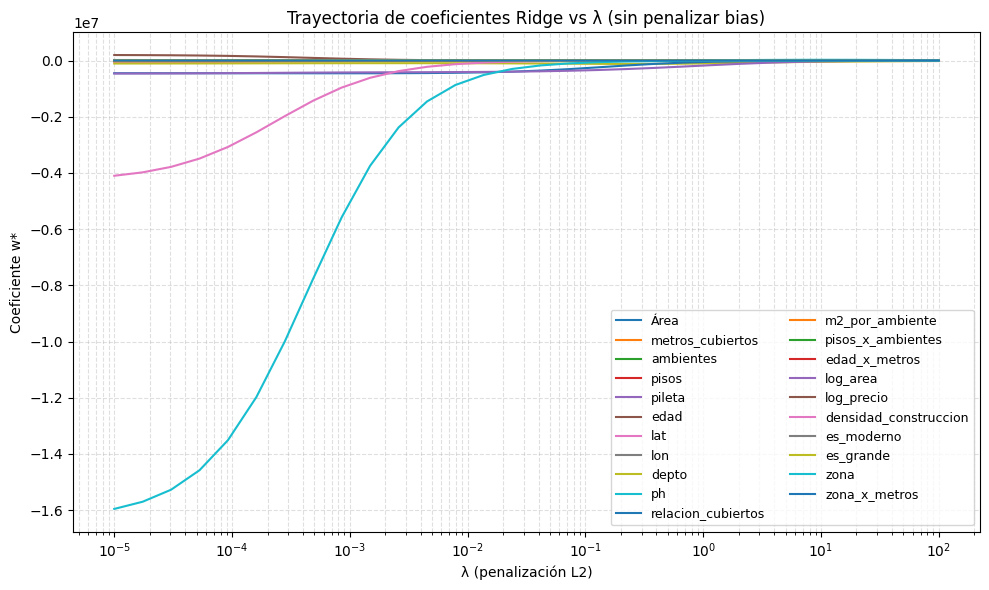

In [73]:
# ----- barrido de lambdas en escala log -----
lambdas = np.logspace(-5, 2, 30)  # desde 1e-3 hasta 1e6
Ws = []  # guardará los coeficientes (incluye bias en el índice 0)

for lam in lambdas:
    modelo = models.RegresionLineal(X_train_m6, y_train_m6, estandarizar=False, feature_names=feature_cols)
    modelo.entrenar_ridge(lam=lam)
    Ws.append(modelo.coef)

Ws = np.array(Ws)  # shape = (len(lambdas), 1 + n_features)

# ----- gráfico: coeficientes (sin bias) vs lambda -----
plt.figure(figsize=(10, 6))
for j, name in enumerate(feature_cols, start=1):  # start=1 para saltearnos bias en col 0
    plt.plot(lambdas, Ws[:, j], label=name)

plt.xscale("log")
plt.xlabel("λ (penalización L2)")
plt.ylabel("Coeficiente w*")
plt.title("Trayectoria de coeficientes Ridge vs λ (sin penalizar bias)")
plt.legend(loc="lower right", ncol=2, fontsize=9)
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [74]:
def lasso_path(
    X, y, feature_cols, lambdas,
    lr=0.5, max_iter=20000, tol=1e-8
):
    """
    Entrena LASSO para distintos λ y devuelve la matriz de coeficientes.
    Retorna:
      lambdas (array), Ws (len(λ) x (1 + n_features))
    """
    Ws = []
    for lam in lambdas:
        model = models.RegresionLineal(X, y, estandarizar=False, feature_names=feature_cols)
        model.entrenar_lasso(lam=lam, lr=lr, max_iter=max_iter, tol=tol, verbose=False)
        Ws.append(model.coef)
    return np.array(lambdas), np.array(Ws)

"""
lambdas = np.logspace(3, 8, 30)  # 1e-6 ... 1e4 (10 décadas)

Ls, Ws = lasso_path(
    X_train_m6, y_train_m6, feature_cols, lambdas,
    lr=1e-3,              # o 5e-4
    max_iter=50000,
    tol=1e-9
)
"""

'\nlambdas = np.logspace(3, 8, 30)  # 1e-6 ... 1e4 (10 décadas)\n\nLs, Ws = lasso_path(\n    X_train_m6, y_train_m6, feature_cols, lambdas,\n    lr=1e-3,              # o 5e-4\n    max_iter=50000,\n    tol=1e-9\n)\n'

In [75]:
# Graficar trayectorias (sin el bias en el plot)
plt.figure(figsize=(10, 6))
for j, name in enumerate(feature_cols, start=1):  # start=1 saltea bias
    plt.plot(Ls, Ws[:, j], label=name)
plt.xscale("log")
plt.xlabel("λ (L1)")
plt.ylabel("Coeficiente w*")
plt.title("Trayectoria de coeficientes LASSO vs λ (bias no penalizado)")
plt.legend(loc="upper left", ncol=2, fontsize=9)
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.tight_layout()
plt.show()

NameError: name 'Ls' is not defined

<Figure size 1000x600 with 0 Axes>

Mejor λ (Ridge): 5.29832e-05 | ECM(CV)=1518024535.058964
Mejor λ (Lasso): 1e-08 | ECM(CV)=1655892416.382647


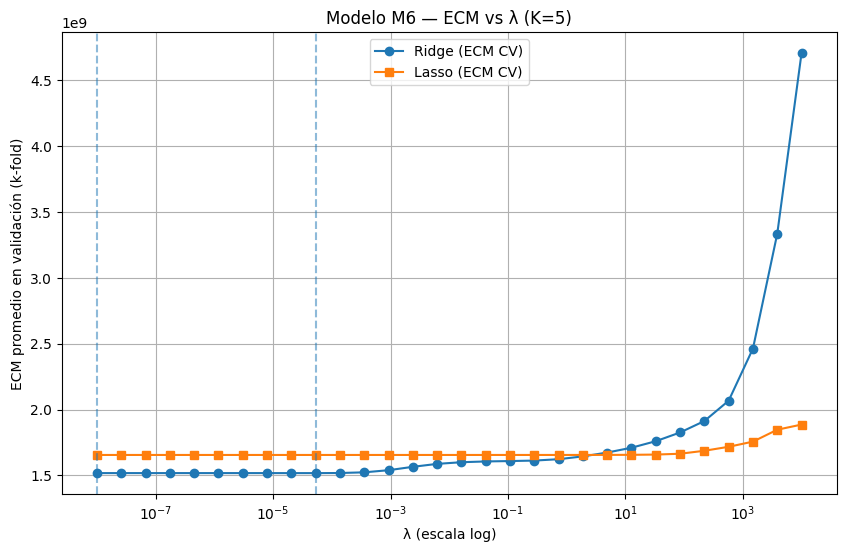

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Tp1.src.models import RegresionLineal
from Tp1.src.metrics import mse
from Tp1.src.preprocessing import normalize

# --- Configuración ---
TARGET = "precio"          # nombre de tu variable objetivo
K = 5                      # número de folds
lambdas = np.logspace(-8, 4, 30)  # grid de λ

# --- Preparar datos (asumimos df ya existe con features + TARGET) ---
n = len(df_feat)
idx = np.arange(n)
rng = np.random.default_rng(42)
rng.shuffle(idx)

fold_sizes = np.full(K, n // K, dtype=int)
fold_sizes[: n % K] += 1
starts = np.cumsum(fold_sizes) - fold_sizes
fold_indices = [idx[s:s+sz] for s, sz in zip(starts, fold_sizes)]

feature_names = [c for c in df_feat.columns if c != TARGET]

def eval_model_for_lambda(lam, mode="ridge"):
    """Devuelve ECM promedio en validación para un λ dado (Ridge o Lasso)."""
    mses = []
    for k in range(K):
        val_idx = fold_indices[k]
        train_idx = np.hstack([fold_indices[i] for i in range(K) if i != k])

        train_df = df_feat.iloc[train_idx].copy()
        val_df   = df_feat.iloc[val_idx].copy()

        # Normalizar por fold (solo features numéricas, dejando TARGET intacto)
        train_norm, val_norm, mu, sigma = normalize(train_df, val_df, target_name=TARGET)

        X_train = train_norm[feature_names].values
        y_train = train_norm[TARGET].values
        X_val   = val_norm[feature_names].values
        y_val   = val_norm[TARGET].values

        model = RegresionLineal(X_train, y_train, estandarizar=False, feature_names=feature_names)

        if mode == "ridge":
            model.entrenar_ridge(lam=lam)
        elif mode == "lasso":
            model.entrenar_lasso(lam=lam, max_iter=5000, tol=1e-6)
        else:
            raise ValueError("mode debe ser 'ridge' o 'lasso'")

        y_pred = model.predecir(X_val)
        mses.append(mse(y_val, y_pred))
    return float(np.mean(mses))

# --- Barrido de λ ---
ridge_cv_mse = [eval_model_for_lambda(lam, mode="ridge") for lam in lambdas]
lasso_cv_mse = [eval_model_for_lambda(lam, mode="lasso") for lam in lambdas]

# --- Selección de λ óptimos ---
best_lambda_ridge = lambdas[int(np.argmin(ridge_cv_mse))]
best_lambda_lasso = lambdas[int(np.argmin(lasso_cv_mse))]

print(f"Mejor λ (Ridge): {best_lambda_ridge:.6g} | ECM(CV)={min(ridge_cv_mse):.6f}")
print(f"Mejor λ (Lasso): {best_lambda_lasso:.6g} | ECM(CV)={min(lasso_cv_mse):.6f}")

# --- Gráfico ECM vs λ ---
plt.figure(figsize=(10,6))
plt.semilogx(lambdas, ridge_cv_mse, marker="o", label="Ridge (ECM CV)")
plt.semilogx(lambdas, lasso_cv_mse, marker="s", label="Lasso (ECM CV)")
plt.axvline(best_lambda_ridge, linestyle="--", alpha=0.5)
plt.axvline(best_lambda_lasso, linestyle="--", alpha=0.5)
plt.xlabel("λ (escala log)")
plt.ylabel("ECM promedio en validación (k-fold)")
plt.title(f"Modelo M6 — ECM vs λ (K={K})")
plt.grid(True)
plt.legend()
plt.show()


c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


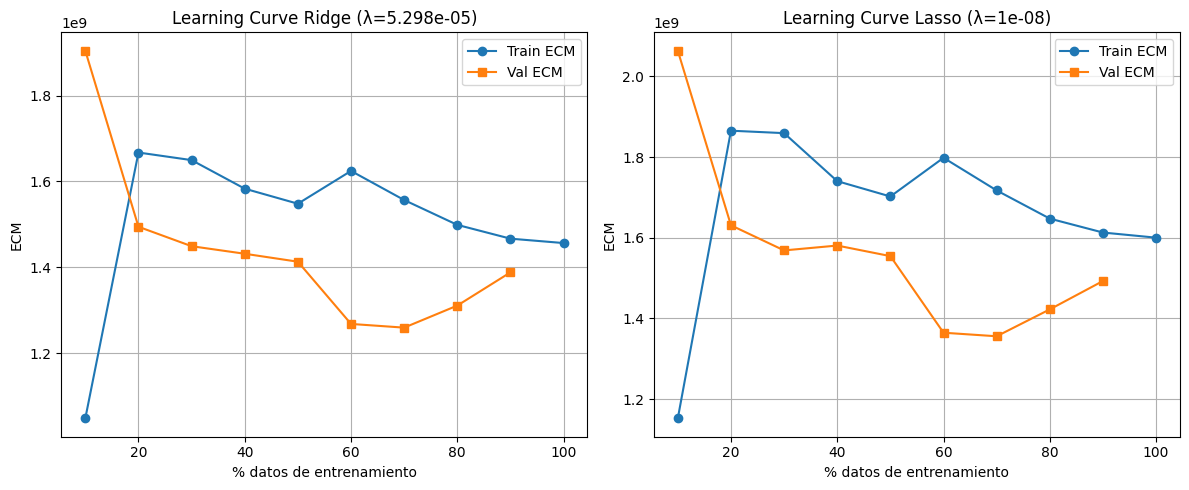

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Tp1.src.models import RegresionLineal
from Tp1.src.metrics import mse
from Tp1.src.preprocessing import normalize

def learning_curve(df, feature_names, TARGET, lam, mode="ridge", n_splits=10):
    """
    Calcula errores de train y val a medida que aumenta el tamaño de train.
    """
    n = len(df)
    sizes = np.linspace(0.1, 1.0, n_splits)  # fracciones del dataset
    train_errors, val_errors = [], []

    for frac in sizes:
        n_train = int(frac * n)
        train_df = df.sample(n=n_train, random_state=42)
        val_df   = df.drop(train_df.index)

        train_norm, val_norm, mu, sigma = normalize(train_df, val_df, target_name=TARGET)

        X_train = train_norm[feature_names].values
        y_train = train_norm[TARGET].values
        X_val   = val_norm[feature_names].values
        y_val   = val_norm[TARGET].values

        model = RegresionLineal(X_train, y_train, estandarizar=False, feature_names=feature_names)

        if mode == "ridge":
            model.entrenar_ridge(lam=lam)
        elif mode == "lasso":
            model.entrenar_lasso(lam=lam, max_iter=5000, tol=1e-6)
        else:
            raise ValueError("mode debe ser 'ridge' o 'lasso'")

        y_pred_train = model.predecir(X_train)
        y_pred_val   = model.predecir(X_val)

        train_errors.append(mse(y_train, y_pred_train))
        val_errors.append(mse(y_val, y_pred_val))

    return sizes * 100, train_errors, val_errors


# --- Parámetros obtenidos en CV ---
lam_ridge = best_lambda_ridge
lam_lasso = best_lambda_lasso

# --- Ridge ---
sizes_ridge, train_ridge, val_ridge = learning_curve(df_feat, feature_names, "precio", lam_ridge, mode="ridge")

# --- Lasso ---
sizes_lasso, train_lasso, val_lasso = learning_curve(df_feat, feature_names, "precio", lam_lasso, mode="lasso")

# --- Graficar ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(sizes_ridge, train_ridge, marker="o", label="Train ECM")
plt.plot(sizes_ridge, val_ridge, marker="s", label="Val ECM")
plt.title(f"Learning Curve Ridge (λ={lam_ridge:.4g})")
plt.xlabel("% datos de entrenamiento")
plt.ylabel("ECM")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(sizes_lasso, train_lasso, marker="o", label="Train ECM")
plt.plot(sizes_lasso, val_lasso, marker="s", label="Val ECM")
plt.title(f"Learning Curve Lasso (λ={lam_lasso:.4g})")
plt.xlabel("% datos de entrenamiento")
plt.ylabel("ECM")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
